

1. Problem statement:

Anomaly detection in ecg signals using GAN

2. Dataset: http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv

3. Objective:

Develop a GAN based model to detect anomalies in ecg signals, distinguishing between normal and abnormal heart rhythms.

4. Proposed Approach:

- Data preprocessing
- Generator Network
- Descriminator Network
- GAN Training
- Anamaly Detection
- Evaluation: Accuracy, precision, recall and F1-score

5. Framework: Pytorch

# **1. Import Necessary Library**

In [ ]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')


# **2. Data preprocessing**

## Read the dataset and identify the dataset shape

In [ ]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
print(f"Dataset shape: {df.shape}")
df.sample(3)


Dataset shape: (4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
3155,-0.619270,-1.253364,-1.440594,-1.976102,-2.042717,-2.079534,-2.166863,-1.998920,-1.796719,-1.570591,...,-1.591761,-2.246771,-2.897495,-3.421550,-4.134913,-4.086949,-3.254277,-3.010393,-1.177498,0.0
4346,0.573209,-0.314216,-1.181473,-2.048512,-2.850995,-3.330855,-3.323015,-2.812867,-2.128474,-1.522603,...,-0.636254,-1.208284,-1.798317,-2.599210,-3.421271,-3.703083,-3.025871,-2.102159,-0.951973,0.0
4639,0.897455,0.521664,-0.049964,-0.536525,-0.790747,-0.963968,-1.252584,-1.441390,-1.480052,-1.362007,...,-2.179214,-2.637056,-3.159356,-3.618413,-4.061323,-4.372594,-3.697316,-3.179952,-1.634316,0.0


## Amount of missing data

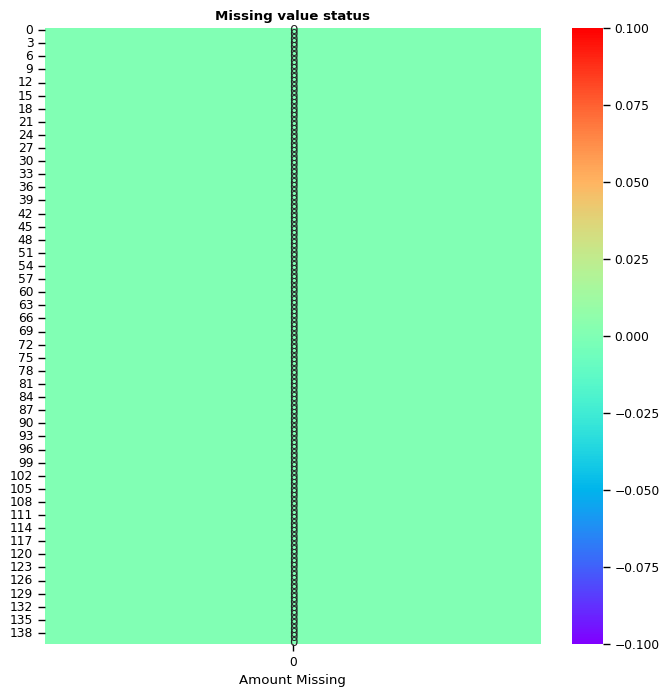

In [ ]:
plt.rc('figure',figsize= (8,8))
sns.set_context('paper',font_scale=1)

plt.title('Missing value status',fontweight = 'bold')
ax = sns.heatmap(df.isnull().sum().to_frame(),annot=True,fmt = 'd',cmap = 'rainbow')
ax.set_xlabel('Amount Missing')
plt.show()



## EDA

In [ ]:
#statistical analysis of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,4998.0,-0.262502,1.152450,-6.729499,-1.004220,-0.297541,0.499909,4.966414
1,4998.0,-1.649828,1.445542,-7.090374,-2.701936,-1.661892,-0.677998,3.479689
2,4998.0,-2.492623,1.386457,-5.132459,-3.668585,-2.586129,-1.514187,2.660597
3,4998.0,-3.119754,1.302921,-5.363241,-4.227337,-3.388210,-2.235690,1.899798
4,4998.0,-3.167656,1.104535,-5.375715,-4.007630,-3.469899,-2.531153,2.147015
...,...,...,...,...,...,...,...,...
136,4998.0,-0.835173,2.056296,-4.880460,-2.868603,-0.195151,0.945027,3.432519
137,4998.0,-0.642739,1.859409,-5.496107,-2.154560,-0.194423,0.951621,3.579448
138,4998.0,-0.487667,1.831088,-5.880890,-1.658289,-0.160262,1.002628,4.425976
139,4998.0,-0.706574,1.414414,-6.092227,-1.596809,-0.568443,0.271635,7.402103


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


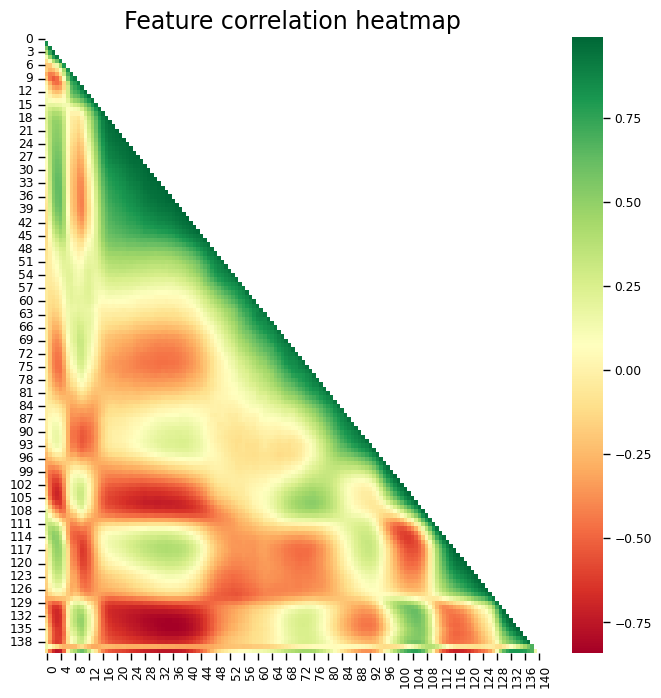

In [ ]:
# Plot dataframe
heat = df.corr().round(5)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(heat)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(8,8))
ax = sns.heatmap(heat, annot=False, mask=mask, cmap="RdYlGn", annot_kws={"weight": "bold", "fontsize":13})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();

In [ ]:
df.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
      dtype='int64', length=141)

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
df.columns

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            131,      132,      133,      134,      135,      136,      137,
            138,      139, 'target'],
      dtype='object', length=141)

In [ ]:
df.target.value_counts()

target
1.0    2919
0.0    2079
Name: count, dtype: int64

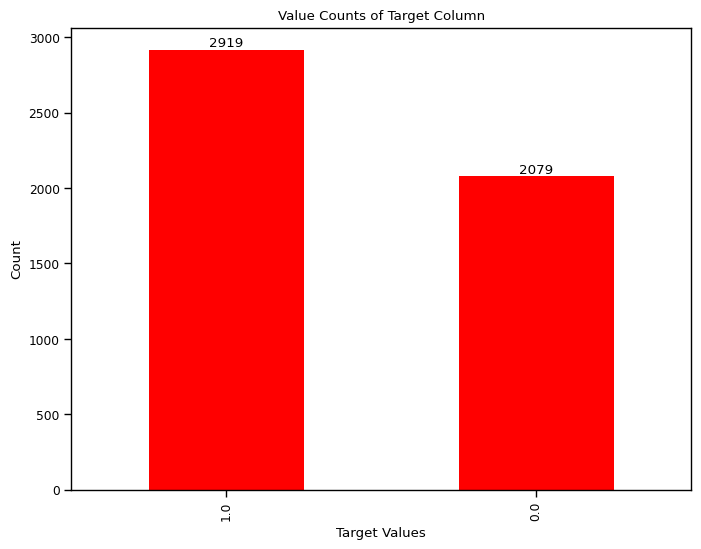

In [ ]:
#plot the value count of normal and abnormal values
value_counts = df['target'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='red')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
classes = df.target.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='red', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

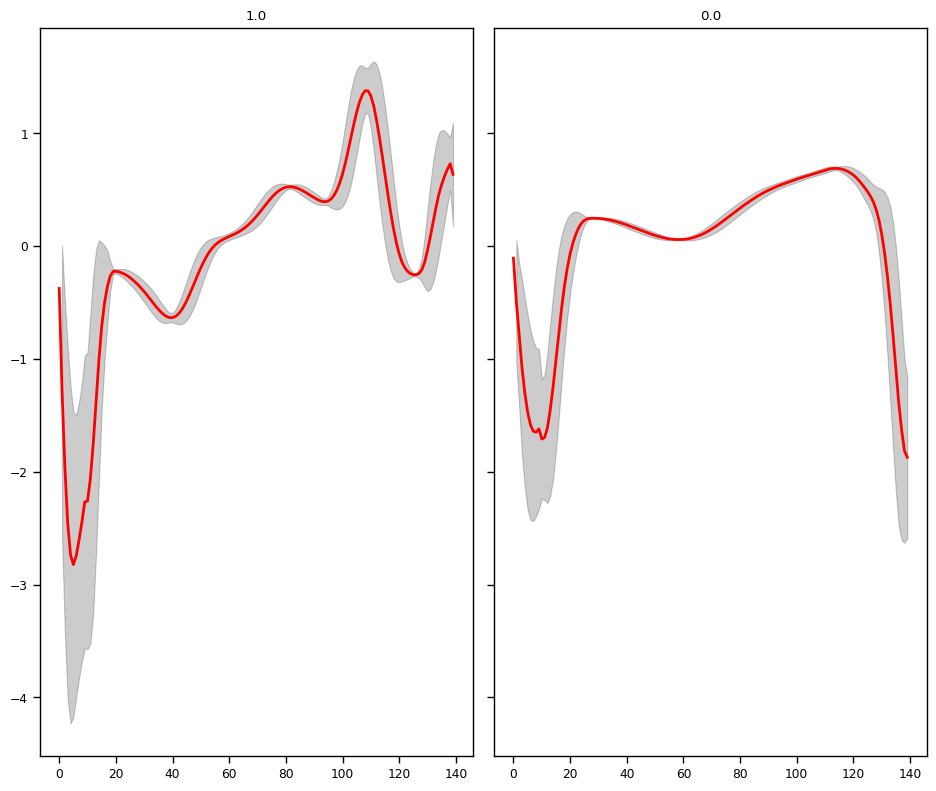

In [ ]:


# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()



# **3. Preparation and Splitting of ECG Data**

In [ ]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
print(f"Normal: {normal_df.shape}")

anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
print(f"Anomaly: {anomaly_df.shape}")

Normal: (2919, 140)
Anomaly: (2079, 140)


In [ ]:
# Splitting the Dataset

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)

# Function to Create a Dataset
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features



In [ ]:

# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# **4. Build the model**

Generator and Discriminator network based on LSTM manner

In [ ]:
#Encoder
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#Decoder
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


In [ ]:
# Autoencoder: Combine encoder and decoder
class Autoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Autoencoder(seq_len, n_features, 128)
model = model.to(device)

cuda


## Helper function ploting and training the model

In [ ]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[0].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()


In [ ]:
def calculate_accuracy(seq_pred, seq_true):
    # Calculate Mean Absolute Error
    mae = torch.mean(torch.abs(seq_pred - seq_true))
    # Calculate accuracy as the inverse of Mean Absolute Error
    accuracy = 1.0 - mae.item() / torch.max(seq_true).item()
    return accuracy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        val_accuracies = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                accuracy = calculate_accuracy(seq_pred, seq_true)

                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

            val_loss = np.mean(val_losses)
            val_accuracy = np.mean(val_accuracies)

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            if val_loss < best_loss:
                best_loss = val_loss
                best_accuracy = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model weights
                print("Saving best model")
                torch.save(model.state_dict(), save_path)

            print(f'Epoch {epoch}: train loss {history["train_loss"][-1]}, val loss {val_loss}, val accuracy {val_accuracy}')

            if epoch == 1 or epoch % 5 == 0:
                plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history


# **5. Train the model and store the best model in locally**

Saving best model
Epoch 1: train loss 61.634803801955165, val loss 56.17199079974804, val accuracy 0.8011484424270096


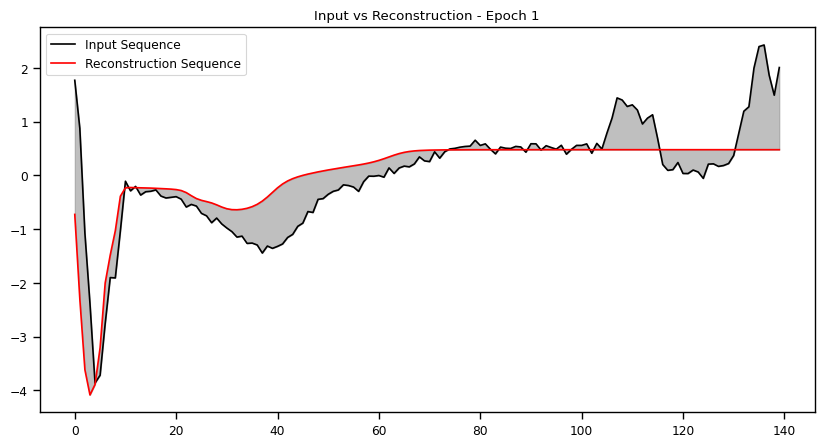

Saving best model
Epoch 2: train loss 55.72818304982122, val loss 54.558473387574836, val accuracy 0.8067906763273825
Saving best model
Epoch 3: train loss 55.27906614193653, val loss 52.66062422359691, val accuracy 0.8132494754305504
Epoch 4: train loss 53.56436871117712, val loss 52.69690084769056, val accuracy 0.812968577850179
Epoch 5: train loss 54.65581897687931, val loss 54.044652789246804, val accuracy 0.8085344229739067


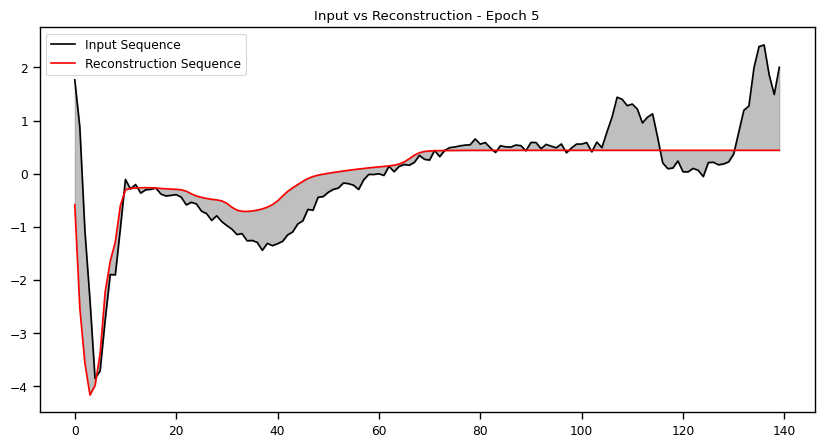

Epoch 6: train loss 54.53225484676584, val loss 54.09466841329936, val accuracy 0.8083519822793267
Epoch 7: train loss 54.86095279092416, val loss 54.07093611573861, val accuracy 0.8084075450460583
Epoch 8: train loss 54.80053084918156, val loss 54.072068532307945, val accuracy 0.8083909036262428
Saving best model
Epoch 9: train loss 54.030545115134544, val loss 48.35083636738896, val accuracy 0.8288096412399798
Saving best model
Epoch 10: train loss 44.072431868000024, val loss 41.5115942612193, val accuracy 0.8529304507120802


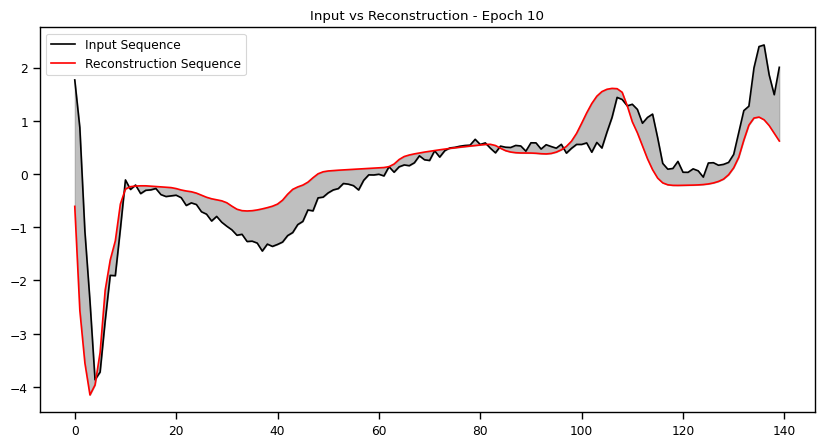

Saving best model
Epoch 11: train loss 41.47153072480183, val loss 40.99934039396398, val accuracy 0.8546723146523458
Saving best model
Epoch 12: train loss 41.16810742869871, val loss 40.019355574464484, val accuracy 0.8582956750216036
Saving best model
Epoch 13: train loss 40.95884299364747, val loss 39.86884620142918, val accuracy 0.8588661306337244
Epoch 14: train loss 40.81298876712035, val loss 39.90029350604886, val accuracy 0.8587333175020548
Epoch 15: train loss 40.68785305130823, val loss 40.01289919310925, val accuracy 0.8583194552630422


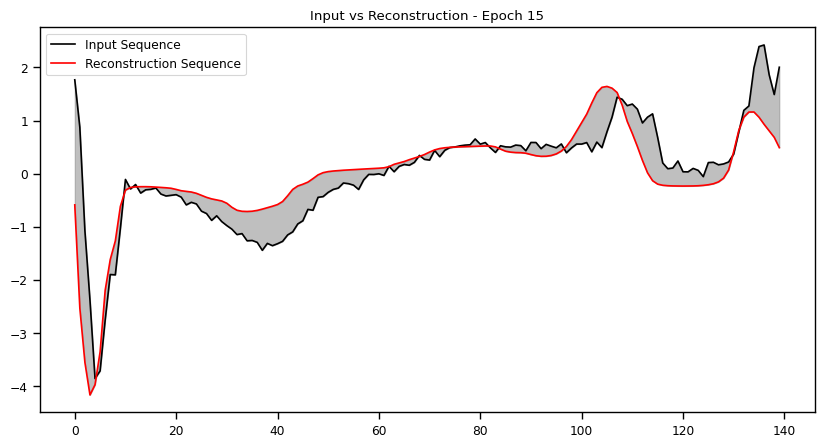

Epoch 16: train loss 40.58837482824483, val loss 40.69011342915055, val accuracy 0.855780553784436
Epoch 17: train loss 40.52805680086996, val loss 40.589978155746955, val accuracy 0.8561502838397281
Saving best model
Epoch 18: train loss 40.5010593388168, val loss 39.84130135704489, val accuracy 0.8589811999630419
Epoch 19: train loss 40.48566532903792, val loss 44.11820619869855, val accuracy 0.8411850802130809
Epoch 20: train loss 41.15377549114174, val loss 41.33252365760554, val accuracy 0.853321871755807


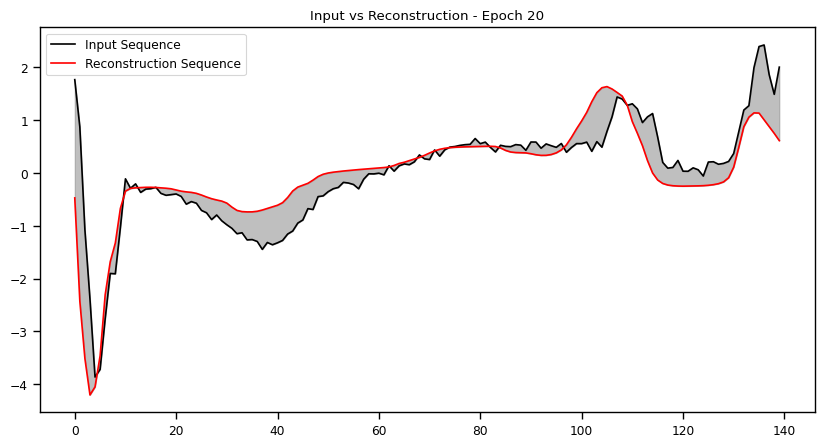

Saving best model
Epoch 21: train loss 40.561755655850675, val loss 39.62478072347205, val accuracy 0.8597651321679799
Saving best model
Epoch 22: train loss 40.584605029397125, val loss 39.48861800923067, val accuracy 0.860209551035164
Epoch 23: train loss 45.997861102241416, val loss 60.96488587373222, val accuracy 0.7840659703637854
Epoch 24: train loss 58.38231410003871, val loss 58.95767254299588, val accuracy 0.7912023692710095
Epoch 25: train loss 57.21419675520282, val loss 57.38218768749362, val accuracy 0.7968000205356324


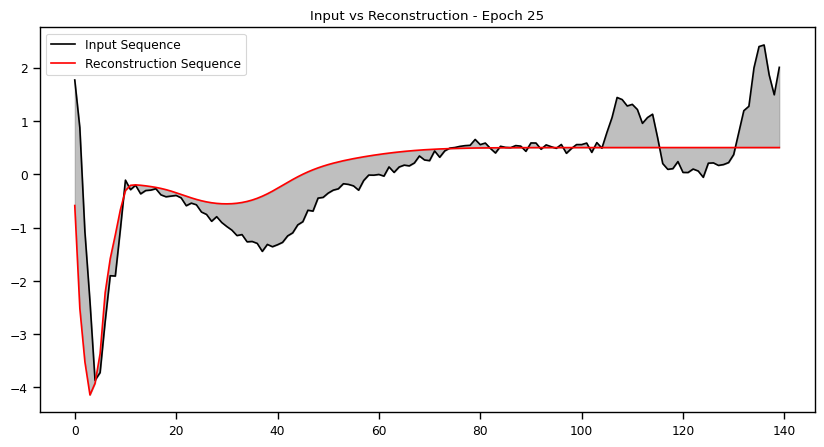

Epoch 26: train loss 56.52682137940978, val loss 56.283929625367804, val accuracy 0.8006971273686615
Epoch 27: train loss 57.96618450461545, val loss 58.528427498013365, val accuracy 0.7926668618816807
Epoch 28: train loss 56.57404881146395, val loss 53.22321062150344, val accuracy 0.8114133168982802
Epoch 29: train loss 53.01797825460807, val loss 50.199386821073645, val accuracy 0.8221212607041642
Epoch 30: train loss 51.435111507491115, val loss 49.114155202130085, val accuracy 0.8260084381440036


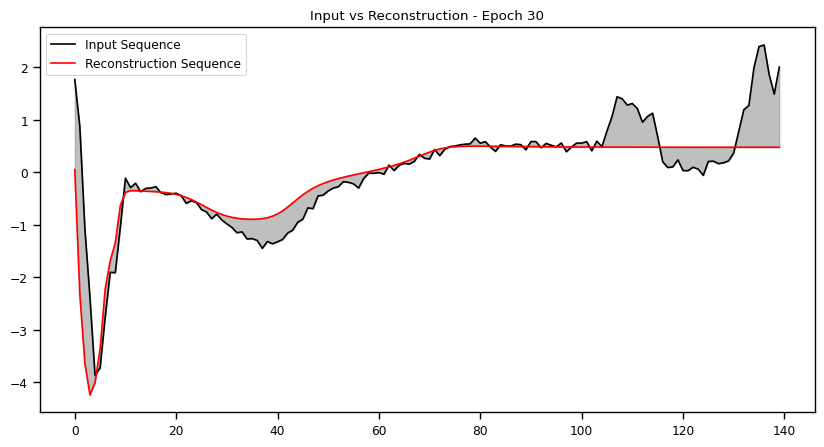

In [ ]:
save_path = '/content/best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, val_dataset, 30, save_path)


## Training vs validation Loss

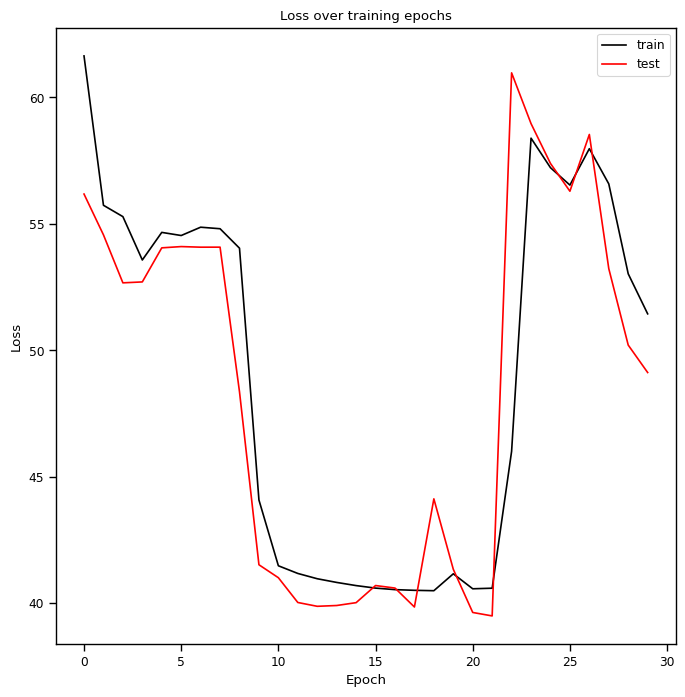

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train_loss'],label='Train Loss', color='black')
ax.plot(history['val_loss'],label='Val Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

# ECG Anomaly Detection Model: Evaluation and Visualization (Accuracy)


In [ ]:
model = Autoencoder(seq_len, n_features, 128)
#use best model
model.load_state_dict(torch.load('/content/best_model.pth'))

model = model.to(device)
model.eval()


Autoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def calculate_accuracy(predictions, dataset):
    accuracies = []
    for pred, true in zip(predictions, dataset):
        true = true.cpu().numpy().flatten()
        mae = np.mean(np.abs(pred - true))
        accuracy = 1.0 - mae / np.max(true)
        accuracies.append(accuracy)
    return np.mean(accuracies)


In [ ]:
predictions,losses = predict(model, train_dataset)
accuracy = calculate_accuracy(predictions, train_dataset)
print(f"Accuracy of the model on the train dataset: {accuracy}")


Accuracy of the model on the train dataset: 0.8555895139773687


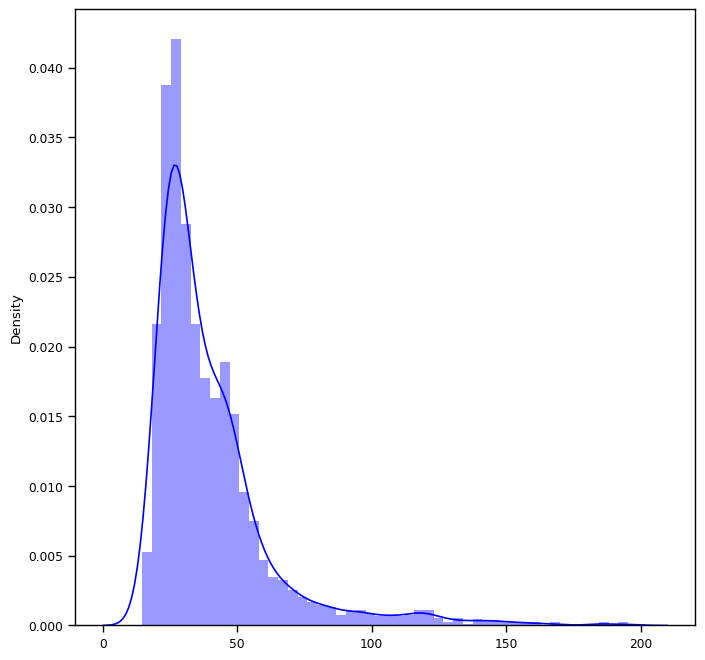

In [ ]:
sns.distplot(losses, bins=50, kde=True, label='Train',color='blue');


Accuracy of the model on the validation dataset: 0.8531844770592271


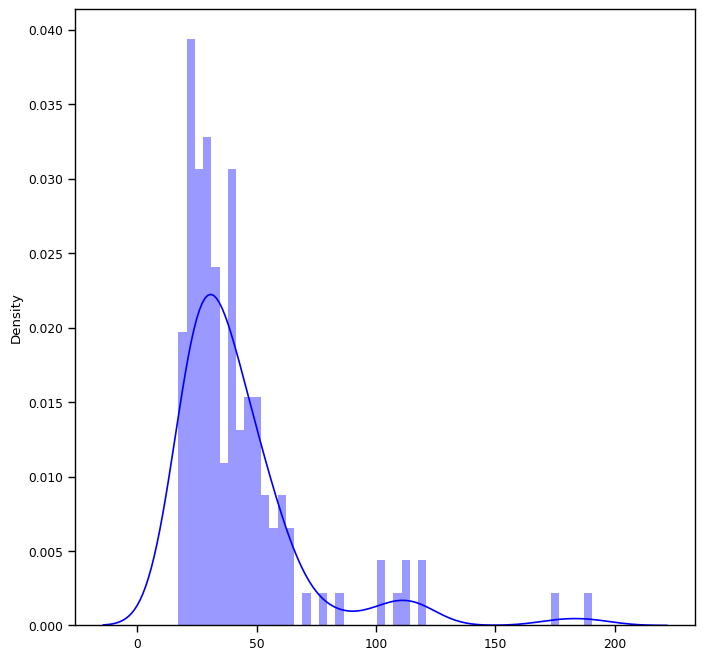

In [ ]:
Threshold = 25
predictions, pred_losses = predict(model, test_normal_dataset)
accuracy = calculate_accuracy(predictions, val_dataset)
print(f"Accuracy of the model on the validation dataset: {accuracy}")
sns.distplot(pred_losses, bins=50, kde=True,color='blue');

In [ ]:

correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 30/132


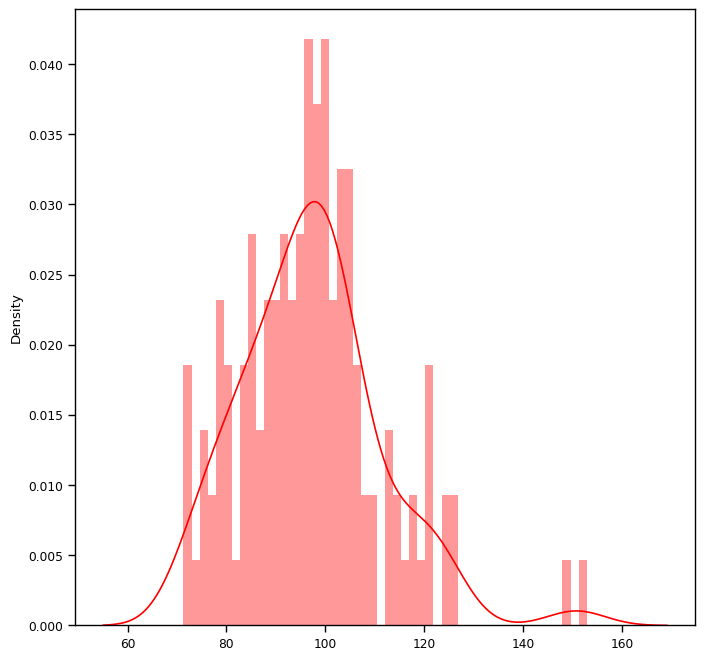

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');


In [ ]:

correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 132/132


-----------------------------------


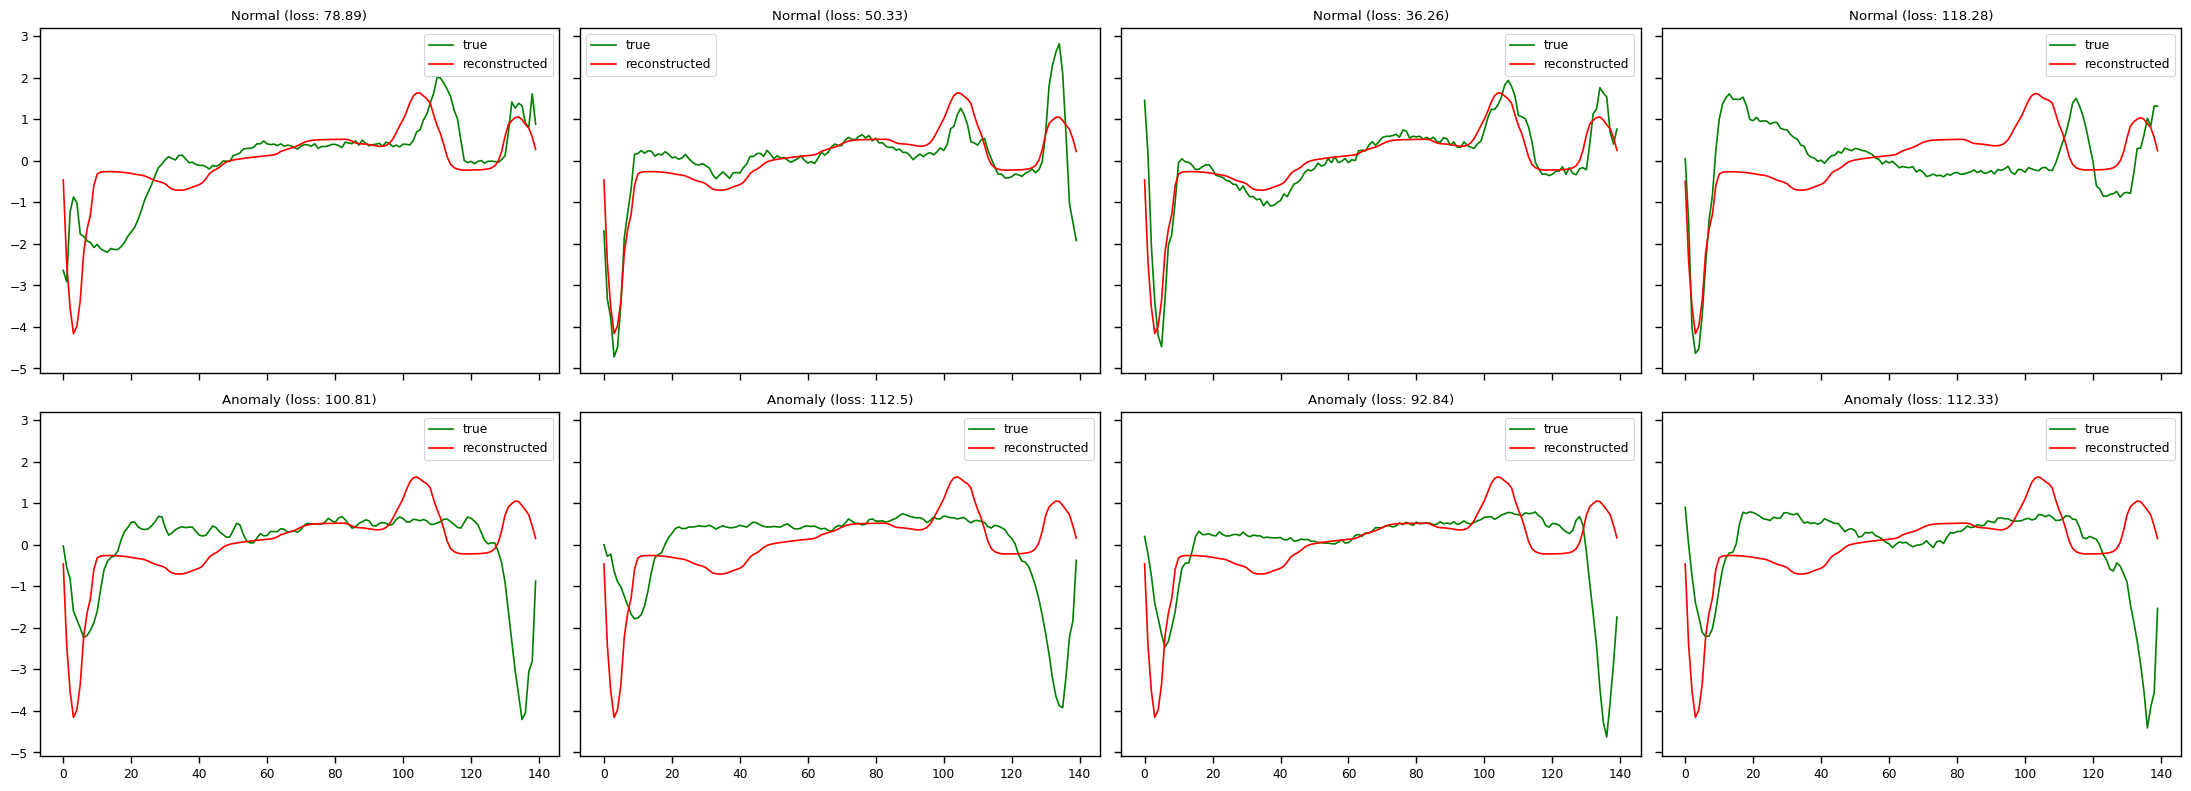

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='green')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

print("-----------------------------------")

fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

# Final Observation:

1. Increase the epoch and increase the accuracy and reduce the losses
2. Hyperparameter changing is require if you want to increase the accuracy and good result of our project
3. If model not work well in real time, change the architecture and  explore the all hyperparameters change to evaluate the model.

Reference:

1. https://github.com/monika-4dec/AI-Fundamentals-Updated/blob/main/GANs/Day%203_4autoencoder.ipynb
2. https://adamoudad.github.io/posts/ecg-anomaly-detection/